# Modeling distributions

The distributions we have used so far are called **empirical
distributions** because they are based on empirical observations, which
are necessarily finite samples.

The alternative is an **analytic distribution**, which is characterized
by a CDF that is a mathematical function. Analytic distributions can be
used to model empirical distributions. In this context, a **model** is a
simplification that leaves out unneeded details. This chapter presents
common analytic distributions and uses them to model data from a variety
of sources.

The code for this chapter is in `analytic.py`. For information about
downloading and working with this code, see
Section [\[code\]](#code){reference-type="ref" reference="code"}.

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [4]:
import numpy as np

import thinkstats2
import thinkplot

## The exponential distribution

I'll start with the **exponential distribution** because it is
relatively simple. The CDF of the exponential distribution is
$$CDF(x) = 1 - e^{-\lambda x}$$ The parameter, $\lambda$, determines
the shape of the distribution.

Figure [\[analytic_expo_cdf\]](#analytic_expo_cdf){reference-type="ref"
reference="analytic_expo_cdf"} shows what this CDF looks like with
$\lambda =$ 0.5, 1, and 2.

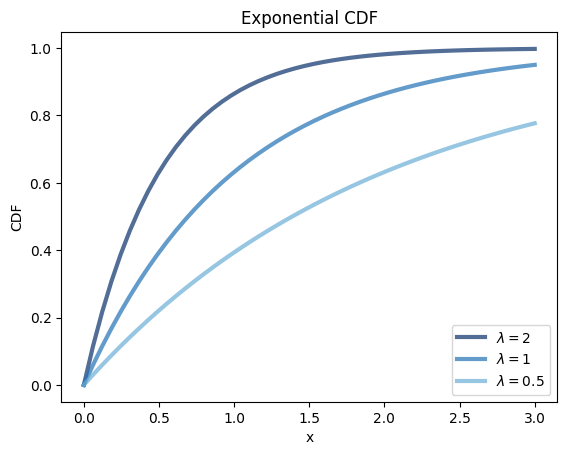

In [5]:
thinkplot.PrePlot(3)
for lam in [2.0, 1, 0.5]:
    xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 3.0, 50)
    label = r"$\lambda=%g$" % lam
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title="Exponential CDF", xlabel="x", ylabel="CDF", loc="lower right")

In the real world, exponential distributions come up when we look at a
series of events and measure the times between events, called
**interarrival times**. If the events are equally likely to occur at any
time, the distribution of interarrival times tends to look like an
exponential distribution.

As an example, we will look at the interarrival time of births. On
December 18, 1997, 44 babies were born in a hospital in Brisbane,
Australia.[^1] The time of birth for all 44 babies was reported in the
local paper; the complete dataset is in a file called `babyboom.dat`, in
the `ThinkStats2` repository.

In [6]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/analytic.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/babyboom.dat")

Downloaded analytic.py
Downloaded babyboom.dat


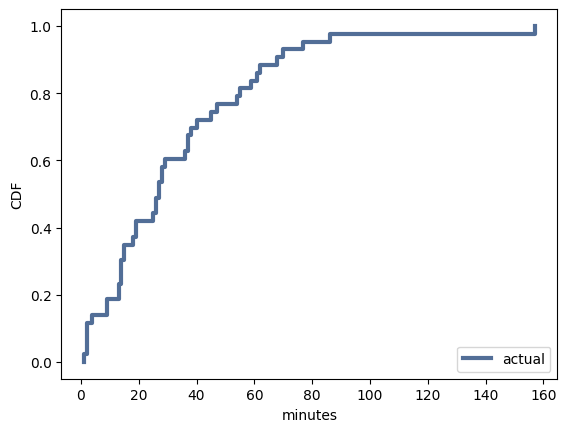

<Figure size 800x600 with 0 Axes>

In [7]:
import analytic

df = analytic.ReadBabyBoom()
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label='actual')

thinkplot.Cdf(cdf)
thinkplot.Show(xlabel='minutes', ylabel='CDF')

`ReadBabyBoom` reads the data file and returns a DataFrame with columns
`time`, `sex`, `weight_g`, and `minutes`, where `minutes` is time of
birth converted to minutes since midnight.

![CDF of interarrival times (left) and CCDF on a log-y scale
(right).](figs/analytic_interarrivals.pdf){height="2.5in"}

`diffs` is the difference between consecutive birth times, and `cdf` is
the distribution of these interarrival times.
Figure [\[analytic_interarrival_cdf\]](#analytic_interarrival_cdf){reference-type="ref"
reference="analytic_interarrival_cdf"} (left) shows the CDF. It seems to
have the general shape of an exponential distribution, but how can we
tell?

One way is to plot the **complementary CDF**, which is $1 - CDF(x)$, on
a log-y scale. For data from an exponential distribution, the result is
a straight line. Let's see why that works.

If you plot the complementary CDF (CCDF) of a dataset that you think is
exponential, you expect to see a function like:
$$y \approx e^{-\lambda x}$$ Taking the log of both sides yields:
$$\log y \approx -\lambda x$$ So on a log-y scale the CCDF is a straight
line with slope $-\lambda$. Here's how we can generate a plot like that:

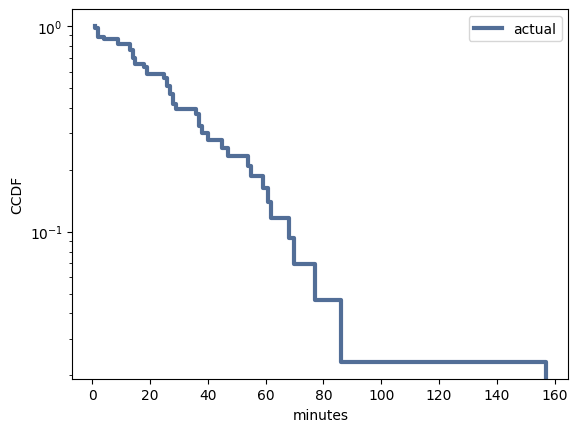

<Figure size 800x600 with 0 Axes>

In [8]:
thinkplot.Cdf(cdf, complement=True)
thinkplot.Show(xlabel='minutes',
               ylabel='CCDF',
               yscale='log')

With the argument `complement=True`, `thinkplot.Cdf` computes the
complementary CDF before plotting. And with `yscale='log'`,
`thinkplot.Show` sets the `y` axis to a logarithmic scale.

Figure [\[analytic_interarrival_cdf\]](#analytic_interarrival_cdf){reference-type="ref"
reference="analytic_interarrival_cdf"} (right) shows the result. It is
not exactly straight, which indicates that the exponential distribution
is not a perfect model for this data. Most likely the underlying
assumption---that a birth is equally likely at any time of day---is not
exactly true. Nevertheless, it might be reasonable to model this dataset
with an exponential distribution. With that simplification, we can
summarize the distribution with a single parameter.

The parameter, $\lambda$, can be interpreted as a rate; that is, the
number of events that occur, on average, in a unit of time. In this
example, 44 babies are born in 24 hours, so the rate is $\lambda =
0.0306$ births per minute. The mean of an exponential distribution is
$1/\lambda$, so the mean time between births is 32.7 minutes.

## The normal distribution

The **normal distribution**, also called Gaussian, is commonly used
because it describes many phenomena, at least approximately. It turns
out that there is a good reason for its ubiquity, which we will get to
in Section [\[CLT\]](#CLT){reference-type="ref" reference="CLT"}.

The normal distribution is characterized by two parameters: the mean,
$\mu$, and standard deviation $\sigma$. The normal distribution with
$\mu=0$ and $\sigma=1$ is called the **standard normal distribution**.
Its CDF is defined by an integral that does not have a closed form
solution, but there are algorithms that evaluate it efficiently. One of
them is provided by SciPy: `scipy.stats.norm` is an object that
represents a normal distribution; it provides a method, `cdf`, that
evaluates the standard normal CDF:

In [9]:
import scipy.stats
scipy.stats.norm.cdf(0)
0.5

0.5

This result is correct: the median of the standard normal distribution
is 0 (the same as the mean), and half of the values fall below the
median, so $CDF(0)$ is 0.5.

`norm.cdf` takes optional parameters: `loc`, which specifies the mean,
and `scale`, which specifies the standard deviation.

`thinkstats2` makes this function a little easier to use by providing
`EvalNormalCdf`, which takes parameters `mu` and `sigma` and evaluates
the CDF at `x`:

In [10]:
def EvalNormalCdf(x, mu=0, sigma=1):
    return scipy.stats.norm.cdf(x, loc=mu, scale=sigma)

Figure [\[analytic_gaussian_cdf\]](#analytic_gaussian_cdf){reference-type="ref"
reference="analytic_gaussian_cdf"} shows CDFs for normal distributions
with a range of parameters. The sigmoid shape of these curves is a
recognizable characteristic of a normal distribution.

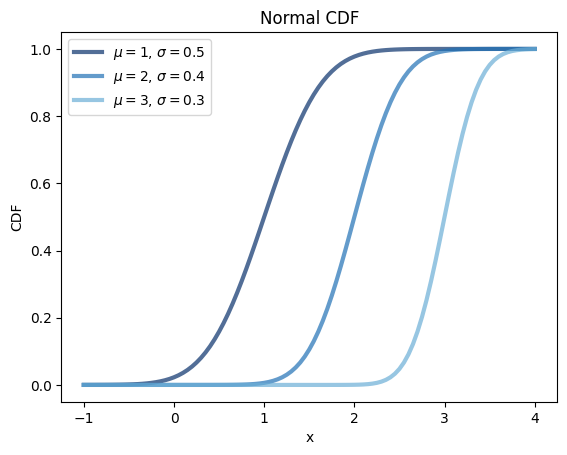

In [11]:
thinkplot.PrePlot(3)

mus = [1.0, 2.0, 3.0]
sigmas = [0.5, 0.4, 0.3]
for mu, sigma in zip(mus, sigmas):
    xs, ps = thinkstats2.RenderNormalCdf(mu=mu, sigma=sigma, low=-1.0, high=4.0)
    label = r"$\mu=%g$, $\sigma=%g$" % (mu, sigma)
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title="Normal CDF", xlabel="x", ylabel="CDF", loc="upper left")

In the previous chapter we looked at the distribution of birth weights
in the NSFG.
Figure [\[analytic_birthwgt_model\]](#analytic_birthwgt_model){reference-type="ref"
reference="analytic_birthwgt_model"} shows the empirical CDF of weights
for all live births and the CDF of a normal distribution with the same
mean and variance.

In [12]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [13]:
import nsfg
import first

preg = nsfg.ReadFemPreg()
weights = preg.totalwgt_lb.dropna()

Mean, Var 7.280883100022579 1.5452125703544897
Sigma 1.2430657948614343


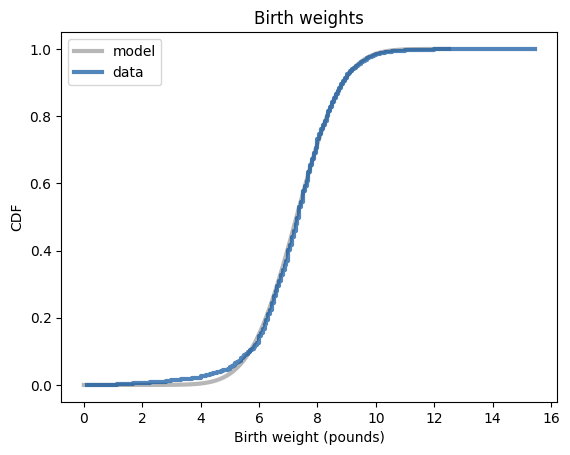

In [14]:
# estimate parameters: trimming outliers yields a better fit
mu, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
print("Mean, Var", mu, var)

# plot the model
sigma = np.sqrt(var)
print("Sigma", sigma)
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=12.5)

thinkplot.Plot(xs, ps, label="model", color="0.6")

# plot the data
cdf = thinkstats2.Cdf(weights, label="data")

thinkplot.PrePlot(1)
thinkplot.Cdf(cdf)
thinkplot.Config(title="Birth weights", xlabel="Birth weight (pounds)", ylabel="CDF")

The normal distribution is a good model for this dataset, so if we
summarize the distribution with the parameters $\mu = 7.28$ and
$\sigma = 1.24$, the resulting error (difference between the model and
the data) is small.

Below the 10th percentile there is a discrepancy between the data and
the model; there are more light babies than we would expect in a normal
distribution. If we are specifically interested in preterm babies, it
would be important to get this part of the distribution right, so it
might not be appropriate to use the normal model.

## Normal probability plot

For the exponential distribution, and a few others, there are simple
transformations we can use to test whether an analytic distribution is a
good model for a dataset.

For the normal distribution there is no such transformation, but there
is an alternative called a **normal probability plot**. There are two
ways to generate a normal probability plot: the hard way and the easy
way. If you are interested in the hard way, you can read about it at
<https://en.wikipedia.org/wiki/Normal_probability_plot>. Here's the easy
way:

1.  Sort the values in the sample.

2.  From a standard normal distribution ($\mu=0$ and $\sigma=1$),
    generate a random sample with the same size as the sample, and sort
    it.

3.  Plot the sorted values from the sample versus the random values.

If the distribution of the sample is approximately normal, the result is
a straight line with intercept `mu` and slope `sigma`. `thinkstats2`
provides `NormalProbability`, which takes a sample and returns two NumPy
arrays:

In [ ]:
xs, ys = thinkstats2.NormalProbability(sample)

`ys` contains the sorted values from `sample`; `xs` contains the random
values from the standard normal distribution.

To test `NormalProbability` I generated some fake samples that were
actually drawn from normal distributions with various parameters.
Figure [\[analytic_normal_prob_example\]](#analytic_normal_prob_example){reference-type="ref"
reference="analytic_normal_prob_example"} shows the results. The lines
are approximately straight, with values in the tails deviating more than
values near the mean.

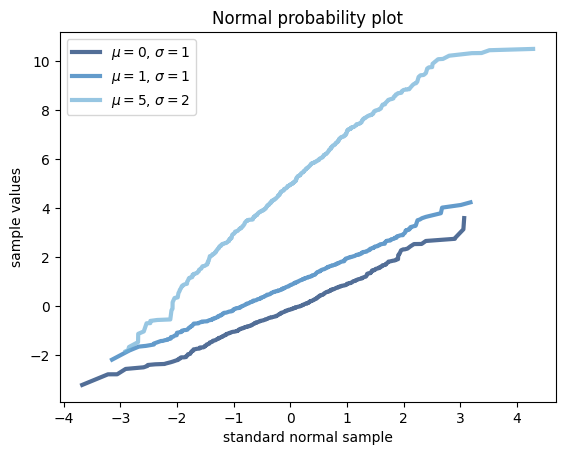

In [15]:
n = 1000
thinkplot.PrePlot(3)

mus = [0, 1, 5]
sigmas = [1, 1, 2]

for mu, sigma in zip(mus, sigmas):
    sample = np.random.normal(mu, sigma, n)
    xs, ys = thinkstats2.NormalProbability(sample)
    label = "$\mu=%d$, $\sigma=%d$" % (mu, sigma)
    thinkplot.Plot(xs, ys, label=label)

thinkplot.Config(
    title="Normal probability plot",
    xlabel="standard normal sample",
    ylabel="sample values",
)

Now let's try it with real data. Here's code to generate a normal
probability plot for the birth weight data from the previous section. It
plots a gray line that represents the model and a blue line that
represents the data.

In [16]:
def MakeNormalPlot(weights):
    mean = weights.mean()
    std = weights.std()

    xs = [-4, 4]
    fxs, fys = thinkstats2.FitLine(xs, inter=mean, slope=std)
    thinkplot.Plot(fxs, fys, color='gray', label='model')

    xs, ys = thinkstats2.NormalProbability(weights)
    thinkplot.Plot(xs, ys, label='birth weights')

`weights` is a pandas Series of birth weights; `mean` and `std` are the
mean and standard deviation.

`FitLine` takes a sequence of `xs`, an intercept, and a slope; it
returns `xs` and `ys` that represent a line with the given parameters,
evaluated at the values in `xs`.

`NormalProbability` returns `xs` and `ys` that contain values from the
standard normal distribution and values from `weights`. If the
distribution of weights is normal, the data should match the model.

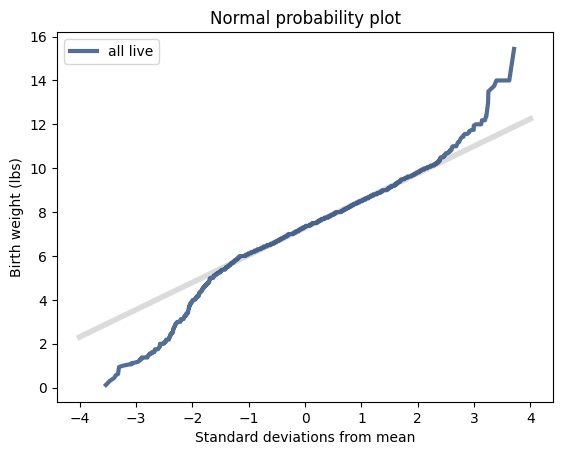

In [17]:
mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
std = np.sqrt(var)

xs = [-4, 4]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color="0.8")

xs, ys = thinkstats2.NormalProbability(weights)
thinkplot.Plot(xs, ys, label="all live")

thinkplot.Config(
    title="Normal probability plot",
    xlabel="Standard deviations from mean",
    ylabel="Birth weight (lbs)",
)

Figure [\[analytic_birthwgt_normal\]](#analytic_birthwgt_normal){reference-type="ref"
reference="analytic_birthwgt_normal"} shows the results for all live
births, and also for full term births (pregnancy length greater than 36
weeks). Both curves match the model near the mean and deviate in the
tails. The heaviest babies are heavier than what the model expects, and
the lightest babies are lighter.

When we select only full term births, we remove some of the lightest
weights, which reduces the discrepancy in the lower tail of the
distribution.

This plot suggests that the normal model describes the distribution well
within a few standard deviations from the mean, but not in the tails.
Whether it is good enough for practical purposes depends on the
purposes.

## The lognormal distribution

If the logarithms of a set of values have a normal distribution, the
values have a **lognormal distribution**. The CDF of the lognormal
distribution is the same as the CDF of the normal distribution, with
$\log x$ substituted for $x$.
$$CDF_{lognormal}(x) = CDF_{normal}(\log x)$$ The parameters of the
lognormal distribution are usually denoted $\mu$ and $\sigma$. But
remember that these parameters are *not* the mean and standard
deviation; the mean of a lognormal distribution is
$\exp(\mu +\sigma^2/2)$ and the standard deviation is ugly (see
<http://wikipedia.org/wiki/Log-normal_distribution>).

If a sample is approximately lognormal and you plot its CDF on a log-x
scale, it will have the characteristic shape of a normal distribution.
To test how well the sample fits a lognormal model, you can make a
normal probability plot using the log of the values in the sample.

As an example, let's look at the distribution of adult weights, which is
approximately lognormal.[^2]

The National Center for Chronic Disease Prevention and Health Promotion
conducts an annual survey as part of the Behavioral Risk Factor
Surveillance System (BRFSS).[^3] In 2008, they interviewed 414,509
respondents and asked about their demographics, health, and health
risks. Among the data they collected are the weights in kilograms of
398,484 respondents.

The repository for this book contains `CDBRFS08.ASC.gz`, a fixed-width
ASCII file that contains data from the BRFSS, and `brfss.py`, which
reads the file and analyzes the data.

In [ ]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [ ]:
import brfss

df = brfss.ReadBrfss()
weights = df.wtkg2.dropna()

In [18]:
def MakeNormalModel(weights):
    """Plots a CDF with a Normal model.

    weights: sequence
    """
    cdf = thinkstats2.Cdf(weights, label="weights")

    mean, var = thinkstats2.TrimmedMeanVar(weights)
    std = np.sqrt(var)
    print("n, mean, std", len(weights), mean, std)

    xmin = mean - 4 * std
    xmax = mean + 4 * std

    xs, ps = thinkstats2.RenderNormalCdf(mean, std, xmin, xmax)
    thinkplot.Plot(xs, ps, label="model", linewidth=4, color="0.8")
    thinkplot.Cdf(cdf)

n, mean, std 9038 7.280883100022579 1.2430657948614343


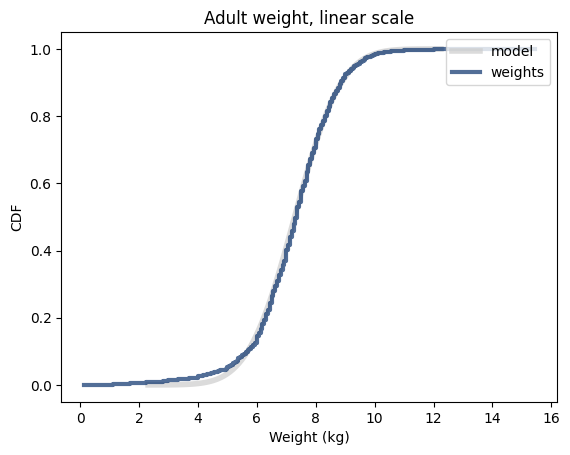

In [19]:
MakeNormalModel(weights)
thinkplot.Config(
    title="Adult weight, linear scale",
    xlabel="Weight (kg)",
    ylabel="CDF",
    loc="upper right",
)

n, mean, std 9038 0.8550971035123834 0.08132700287556055


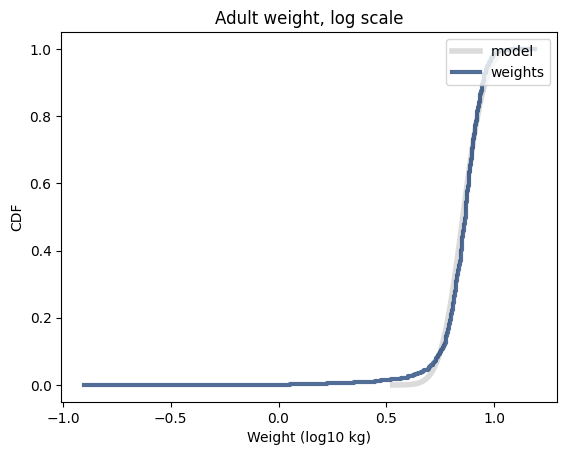

In [20]:
log_weights = np.log10(weights)
MakeNormalModel(log_weights)
thinkplot.Config(
    title="Adult weight, log scale",
    xlabel="Weight (log10 kg)",
    ylabel="CDF",
    loc="upper right",
)

Figure [\[brfss_weight\]](#brfss_weight){reference-type="ref"
reference="brfss_weight"} (left) shows the distribution of adult weights
on a linear scale with a normal model.
Figure [\[brfss_weight\]](#brfss_weight){reference-type="ref"
reference="brfss_weight"} (right) shows the same distribution on a log
scale with a lognormal model. The lognormal model is a better fit, but
this representation of the data does not make the difference
particularly dramatic.

Figure [\[brfss_weight_normal\]](#brfss_weight_normal){reference-type="ref"
reference="brfss_weight_normal"} shows normal probability plots for
adult weights, $w$, and for their logarithms, $\log_{10} w$. Now it is
apparent that the data deviate substantially from the normal model. On
the other hand, the lognormal model is a good match for the data.

## The Pareto distribution

The **Pareto distribution** is named after the economist Vilfredo
Pareto, who used it to describe the distribution of wealth (see
<http://wikipedia.org/wiki/Pareto_distribution>). Since then, it has
been used to describe phenomena in the natural and social sciences
including sizes of cities and towns, sand particles and meteorites,
forest fires and earthquakes.

The CDF of the Pareto distribution is:
$$CDF(x) = 1 - \left( \frac{x}{x_m} \right) ^{-\alpha}$$ The parameters
$x_{m}$ and $\alpha$ determine the location and shape of the
distribution. $x_{m}$ is the minimum possible value.
Figure [\[analytic_pareto_cdf\]](#analytic_pareto_cdf){reference-type="ref"
reference="analytic_pareto_cdf"} shows CDFs of Pareto distributions with
$x_{m} = 0.5$ and different values of $\alpha$.

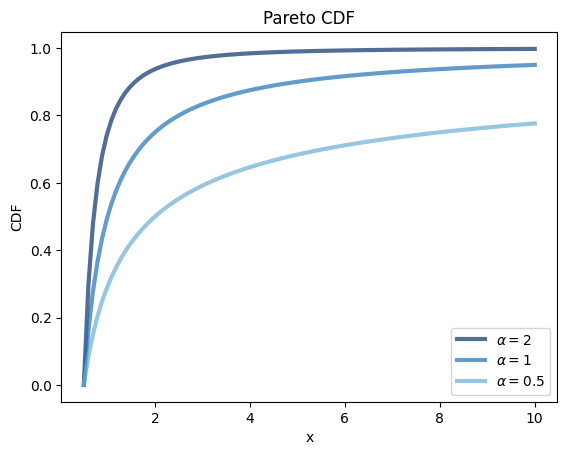

In [21]:
xmin = 0.5

thinkplot.PrePlot(3)
for alpha in [2.0, 1.0, 0.5]:
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100)
    thinkplot.Plot(xs, ps, label=r"$\alpha=%g$" % alpha)

thinkplot.Config(title="Pareto CDF", xlabel="x", ylabel="CDF", loc="lower right")

There is a simple visual test that indicates whether an empirical
distribution fits a Pareto distribution: on a log-log scale, the CCDF
looks like a straight line. Let's see why that works.

If you plot the CCDF of a sample from a Pareto distribution on a linear
scale, you expect to see a function like:
$$y \approx \left( \frac{x}{x_m} \right) ^{-\alpha}$$ Taking the log of
both sides yields: $$\log y \approx -\alpha (\log x - \log x_{m})$$ So
if you plot $\log y$ versus $\log x$, it should look like a straight
line with slope $-\alpha$ and intercept $\alpha \log x_{m}$.

As an example, let's look at the sizes of cities and towns. The
U.S. Census Bureau publishes the population of every incorporated city
and town in the United States.

In [22]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/populations.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/PEP_2012_PEPANNRES_with_ann.csv")

Downloaded populations.py
Downloaded PEP_2012_PEPANNRES_with_ann.csv


In [23]:
import populations

pops = populations.ReadData()
print("Number of cities/towns", len(pops))

Number of cities/towns 19515


I downloaded their data from
<http://www.census.gov/popest/data/cities/totals/2012/SUB-EST2012-3.html>;
it is in the repository for this book in a file named
`PEP_2012_PEPANNRES_with_ann.csv`. The repository also contains
`populations.py`, which reads the file and plots the distribution of
populations.

Figure [\[populations_pareto\]](#populations_pareto){reference-type="ref"
reference="populations_pareto"} shows the CCDF of populations on a
log-log scale. The largest 1% of cities and towns, below $10^{-2}$, fall
along a straight line. So we could conclude, as some researchers have,
that the tail of this distribution fits a Pareto model.

On the other hand, a lognormal distribution also models the data well.
Figure [\[populations_normal\]](#populations_normal){reference-type="ref"
reference="populations_normal"} shows the CDF of populations and a
lognormal model (left), and a normal probability plot (right). Both
plots show good agreement between the data and the model.

Neither model is perfect. The Pareto model only applies to the largest
1% of cities, but it is a better fit for that part of the distribution.
The lognormal model is a better fit for the other 99%. Which model is
appropriate depends on which part of the distribution is relevant.

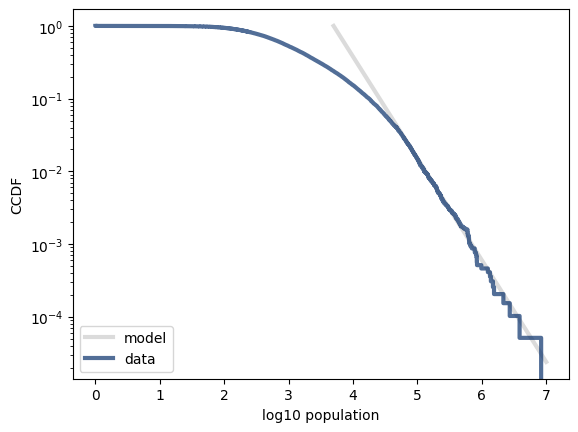

In [24]:
log_pops = np.log10(pops)
cdf = thinkstats2.Cdf(pops, label="data")
cdf_log = thinkstats2.Cdf(log_pops, label="data")

# pareto plot
xs, ys = thinkstats2.RenderParetoCdf(xmin=5000, alpha=1.4, low=0, high=1e7)
thinkplot.Plot(np.log10(xs), 1 - ys, label="model", color="0.8")

thinkplot.Cdf(cdf_log, complement=True)
thinkplot.Config(
    xlabel="log10 population", ylabel="CCDF", yscale="log", loc="lower left"
)

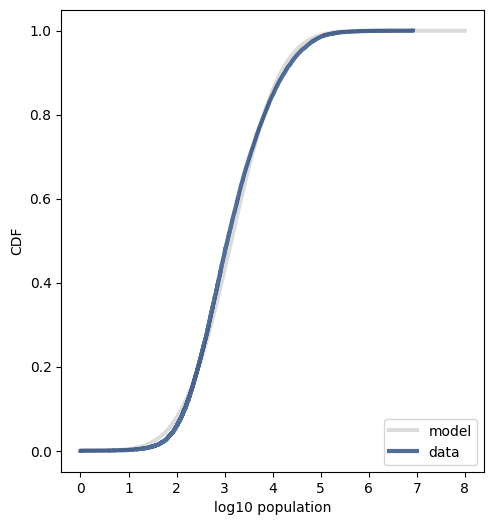

In [25]:
thinkplot.PrePlot(cols=2)

mu, sigma = log_pops.mean(), log_pops.std()
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=8)
thinkplot.Plot(xs, ps, label="model", color="0.8")

thinkplot.Cdf(cdf_log)
thinkplot.Config(xlabel="log10 population", ylabel="CDF", loc="lower right")

## Generating random numbers

Analytic CDFs can be used to generate random numbers with a given
distribution function, $p = CDF(x)$. If there is an efficient way to
compute the inverse CDF, we can generate random values with the
appropriate distribution by choosing $p$ from a uniform distribution
between 0 and 1, then choosing $x = ICDF(p)$.

For example, the CDF of the exponential distribution is
$$p = 1 - e^{-\lambda x}$$ Solving for $x$ yields:
$$x = -\log (1 - p) / \lambda$$ So in Python we can write

In [30]:
import random

def expovariate(lam):
    p = random.random()
    x = -np.log(1-p) / lam
    return x

`expovariate` takes `lam` and returns a random value chosen from the
exponential distribution with parameter `lam`.

Two notes about this implementation: I called the parameter `lam`
because `lambda` is a Python keyword. Also, since $\log 0$ is undefined,
we have to be a little careful. The implementation of `random.random`
can return 0 but not 1, so $1 - p$ can be 1 but not 0, so `log(1-p)` is
always defined.

In [31]:
t = [expovariate(lam=2) for _ in range(1000)]

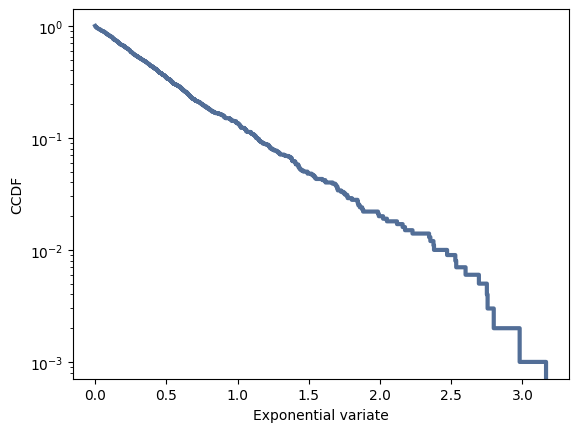

In [32]:
cdf = thinkstats2.Cdf(t)

thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel="Exponential variate", ylabel="CCDF", yscale="log")

## Why model?

At the beginning of this chapter, I said that many real world phenomena
can be modeled with analytic distributions. "So," you might ask, "what?"

Like all models, analytic distributions are abstractions, which means
they leave out details that are considered irrelevant. For example, an
observed distribution might have measurement errors or quirks that are
specific to the sample; analytic models smooth out these idiosyncrasies.

Analytic models are also a form of data compression. When a model fits a
dataset well, a small set of parameters can summarize a large amount of
data.

It is sometimes surprising when data from a natural phenomenon fit an
analytic distribution, but these observations can provide insight into
physical systems. Sometimes we can explain why an observed distribution
has a particular form. For example, Pareto distributions are often the
result of generative processes with positive feedback (so-called
preferential attachment processes: see
<http://wikipedia.org/wiki/Preferential_attachment>.).

Also, analytic distributions lend themselves to mathematical analysis,
as we will see in Chapter [\[analysis\]](#analysis){reference-type="ref"
reference="analysis"}.

But it is important to remember that all models are imperfect. Data from
the real world never fit an analytic distribution perfectly. People
sometimes talk as if data are generated by models; for example, they
might say that the distribution of human heights is normal, or the
distribution of income is lognormal. Taken literally, these claims
cannot be true; there are always differences between the real world and
mathematical models.

Models are useful if they capture the relevant aspects of the real world
and leave out unneeded details. But what is "relevant" or "unneeded"
depends on what you are planning to use the model for.

A straight line is consistent with an exponential distribution.

## Exercises

**Exercise:** Write a function that generates a Pareto variate. Generate a sample and plot its complementary CDF on a log-log scale. Does it look like a straight line?

In [35]:
# Solution


def sample_pareto(alpha, x_m, size):
    u = np.random.random(size)
    return x_m * pow(1 - u, -1 / alpha)

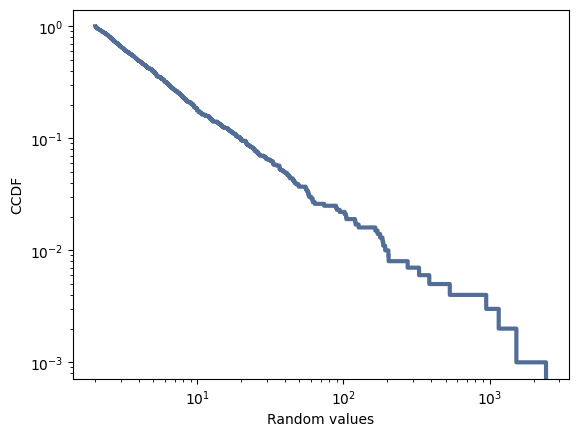

In [36]:
# Solution

sample = sample_pareto(1, 2, 1000)
cdf = thinkstats2.Cdf(sample)

thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel="Random values", ylabel="CCDF", xscale="log", yscale="log")

**Exercise:** In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

`scipy.stats` contains objects that represent analytic distributions

In [37]:
import scipy.stats

For example <tt>scipy.stats.norm</tt> represents a normal distribution.

In [38]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_continuous_frozen

A "frozen random variable" can compute its mean and standard deviation.

In [39]:
dist.mean(), dist.std()

(178.0, 7.7)

It can also evaluate its CDF.  How many people are below the mean by more than one standard deviation?  About 16%

In [40]:
dist.cdf(mu - sigma)

0.1586552539314574

How many people are between 5'10" and 6'1"?

In [41]:
# Solution

low = dist.cdf(177.8)  # 5'10"
high = dist.cdf(185.4)  # 6'1"
low, high, high - low

(0.48963902786483265, 0.8317337108107857, 0.3420946829459531)

**Exercise:** To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [42]:
alpha = 1.7
xmin = 1  # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

1.5034066538560549

What is the mean height in Pareto world?

In [43]:
# Solution

dist.mean()

2.428571428571429

What fraction of people are shorter than the mean?

In [44]:
# Solution

dist.cdf(dist.mean())

0.778739697565288

Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [45]:
# Solution

(1 - dist.cdf(1000)) * 7e9, dist.sf(1000) * 7e9

(55602.976430479954, 55602.97643069972)

How tall do we expect the tallest person to be?

In [46]:
# Solution

# One way to solve this is to search for a height that we
# expect one person out of 7 billion to exceed.

# It comes in at roughly 600 kilometers.

dist.sf(600000) * 7e9

1.0525455861201714

In [47]:
# Solution

# Another way is to use `ppf`, which evaluates the "percent point function", which
# is the inverse CDF.  So we can compute the height in meters that corresponds to
# the probability (1 - 1/7e9).

dist.ppf(1 - 1 / 7e9)

618349.6106759505

**Exercise:** The Weibull distribution is a generalization of the exponential distribution that comes up in failure analysis (see http://wikipedia.org/wiki/Weibull_distribution). Its CDF is

$\mathrm{CDF}(x) = 1 − \exp[−(x / λ)^k]$ 

Can you find a transformation that makes a Weibull distribution look like a straight line? What do the slope and intercept of the line indicate?

Use `random.weibullvariate` to generate a sample from a Weibull distribution and use it to test your transformation.

Generate a sample from a Weibull distribution and plot it using a transform that makes a Weibull distribution look like a straight line.

If you are stuck, you can get a hint from `thinkplot.Cdf`, which provides a transform that makes the CDF of a Weibull distribution look like a straight line.  Here's an example that shows how it's used.

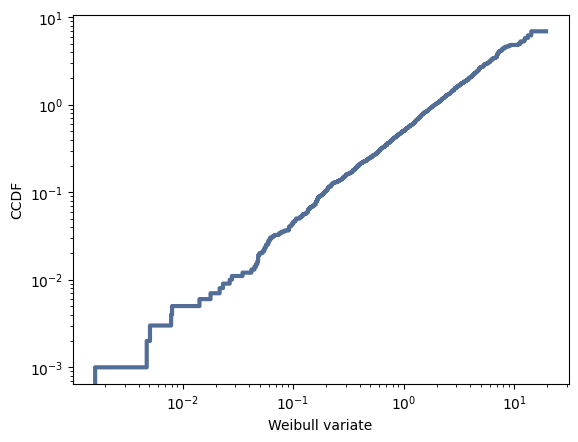

In [48]:
sample = [random.weibullvariate(2, 1) for _ in range(1000)]
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf, transform="weibull")
thinkplot.Config(xlabel="Weibull variate", ylabel="CCDF", 
                 xscale="log", yscale="log")

**Exercise:** For small values of `n`, we don’t expect an empirical distribution to fit an analytic distribution exactly. One way to evaluate the quality of fit is to generate a sample from an analytic distribution and see how well it matches the data.

For example, in Section 5.1 we plotted the distribution of time between births and saw that it is approximately exponential. But the distribution is based on only 44 data points. To see whether the data might have come from an exponential distribution, generate 44 values from an exponential distribution with the same mean as the data, about 33 minutes between births.

Plot the distribution of the random values and compare it to the actual distribution. You can use random.expovariate to generate the values.

In [49]:
import analytic

df = analytic.ReadBabyBoom()
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label="actual")

n = len(diffs)
lam = 44.0 / 24 / 60
sample = [random.expovariate(lam) for _ in range(n)]

1 / lam, np.mean(sample)

(32.72727272727273, 28.768326594024213)

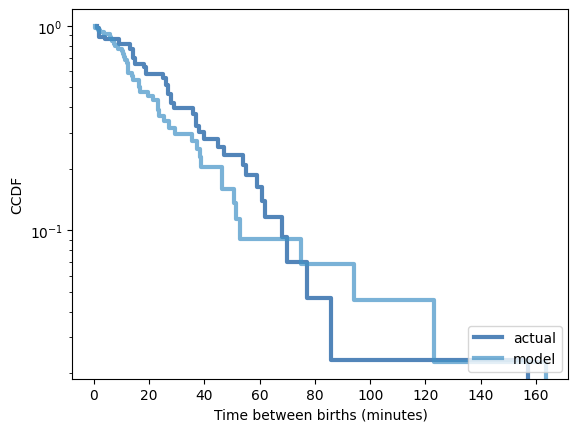

In [50]:
# Solution

model = thinkstats2.Cdf(sample, label='model')
    
thinkplot.PrePlot(2)
thinkplot.Cdfs([cdf, model], complement=True)
thinkplot.Config(xlabel='Time between births (minutes)',
                ylabel='CCDF',
                yscale='log')


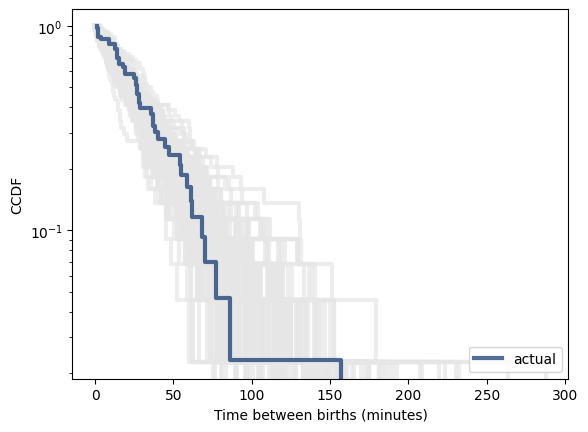

In [51]:
# Solution

# If you plot distributions for a large number of samples, you get a sense
# of how much random variation to expect.  In this case, the data fall within
# the range we expect, so there is no compelling reason to think it is
# not exponential.

for i in range(100):
    sample = [random.expovariate(lam) for _ in range(n)]
    thinkplot.Cdf(thinkstats2.Cdf(sample), complement=True, color="0.9")

thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel="Time between births (minutes)", ylabel="CCDF", yscale="log")

**Bonus Example:** The distributions of wealth and income are sometimes modeled using lognormal and Pareto distributions. To see which is better, let’s look at some data.

The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc.py`, which reads this file.

Extract the distribution of incomes from this dataset. Are any of the analytic distributions in this chapter a good model of the data?

In [52]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

Downloaded hinc.py
Downloaded hinc06.csv


In [53]:
import hinc

df = hinc.ReadData()
df

,income,freq,cumsum,ps
0,4999.0,4204,4204,0.034330
1,9999.0,4729,8933,0.072947
2,14999.0,6982,15915,0.129963
3,19999.0,7157,23072,0.188407
4,24999.0,7131,30203,0.246640
5,29999.0,6740,36943,0.301679
6,34999.0,6354,43297,0.353566
7,39999.0,5832,49129,0.401191
8,44999.0,5547,54676,0.446488
9,49999.0,5254,59930,0.489392


Here's what the CDF looks like on a linear scale.

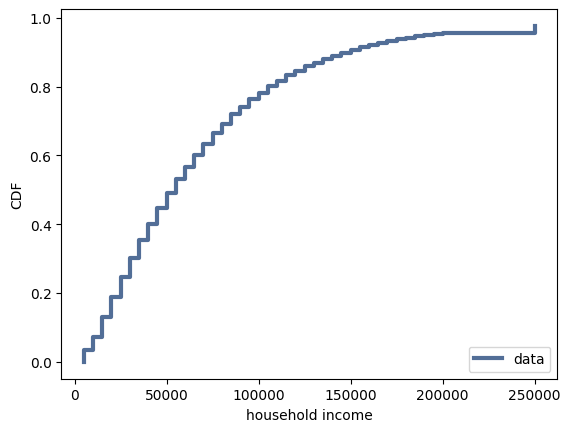

In [54]:
xs, ps = df.income.values, df.ps.values
cdf = thinkstats2.Cdf(xs, ps, label="data")
cdf_log = thinkstats2.Cdf(np.log10(xs), ps, label="data")

# linear plot
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel="household income", ylabel="CDF")

To check whether a Pareto model describes the data well, I plot the CCDF on a log-log scale.

I found parameters for the Pareto model that match the tail of the distribution.

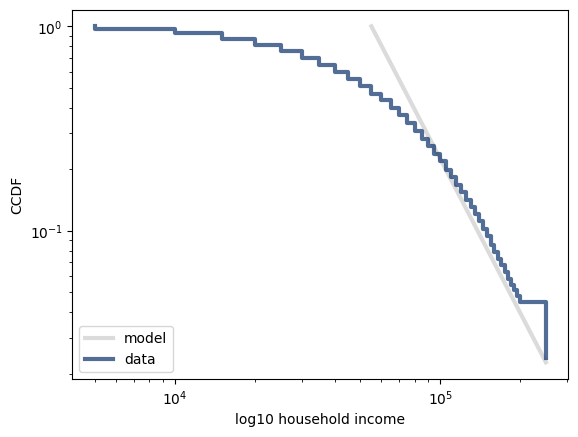

In [55]:
xs, ys = thinkstats2.RenderParetoCdf(xmin=55000, alpha=2.5, low=0, high=250000)

thinkplot.Plot(xs, 1 - ys, label="model", color="0.8")

thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(
    xlabel="log10 household income",
    ylabel="CCDF",
    xscale="log",
    yscale="log",
    loc="lower left",
)

For the lognormal model I estimate mu and sigma using percentile-based statistics (median and IQR).

In [56]:
median = cdf_log.Percentile(50)
iqr = cdf_log.Percentile(75) - cdf_log.Percentile(25)
std = iqr / 1.349

# choose std to match the upper tail
std = 0.35
print(median, std)

4.740354793159152 0.35


Here's what the distribution, and fitted model, look like on a log-x scale.

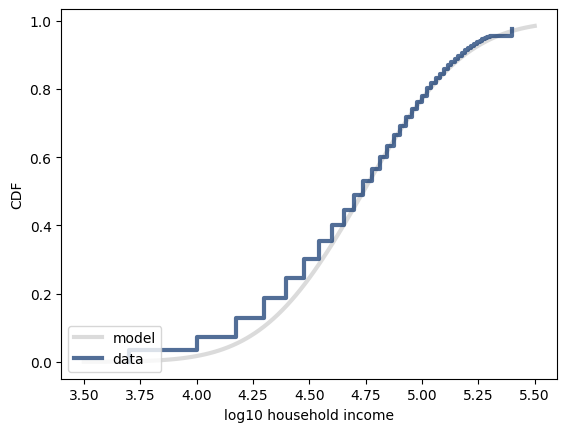

In [57]:
xs, ps = thinkstats2.RenderNormalCdf(median, std, low=3.5, high=5.5)
thinkplot.Plot(xs, ps, label="model", color="0.8")

thinkplot.Cdf(cdf_log)
thinkplot.Config(xlabel="log10 household income", ylabel="CDF")

My conclusions based on these figures are:

1) The Pareto model might be a reasonable choice for the top
   10-20% of incomes.

2) The lognormal model captures the shape of the distribution better,
   with some deviation in the left tail.  With different
   choices for sigma, you could match the upper or lower tail, but not
   both at the same time.
 
In summary I would say that neither model captures the whole distribution,
so you might have to 

1) look for another analytic model, 

2) choose one that captures the part of the distribution that is most 
   relevent, or 

3) avoid using an analytic model altogether.